In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit,minimize
from HOTRG import get_lattice_size,get_dist_torus_2D,get_dist_2D
import matplotlib as mpl
import importlib
import correlation_ansatzs
importlib.reload(correlation_ansatzs)
from correlation_ansatzs import high_temp_correlation,low_temp_correlation,low_temp_correlation_1,low_temp_correlation_2,critical_correlation,loglog

%matplotlib inline

def process_data(filename,log2Size=30):
    data=pd.read_pickle(filename)
    lattice_size=get_lattice_size(nLayers=2*log2Size,spacial_dim=2)
    data['x']=data.apply(lambda row:row['x1']-row['x0'],axis=1)
    data['y']=data.apply(lambda row:row['y1']-row['y0'],axis=1)
    data['dist']=data.apply(lambda row:get_dist_torus_2D(row['x'],row['y'],lattice_size),axis=1)
    data['theta']=data.apply(lambda row:np.arctan2(row['y'],row['x']),axis=1)
    data=data.sort_values(by=['dist'])
    return data


def fitWithHuberLoss(ansatz,x,y,p0=None,epsilon=1,
                             allow_positive_outliers=True,allow_negative_outliers=True):
    def loss(xs,ys,*p):
        dist=ys-ansatz(xs,*p)
        loss1=1/2 * dist**2 # lsq
        loss2=epsilon*(np.abs(dist)-epsilon/2) # huber
        if allow_positive_outliers:
            loss1[dist>epsilon]=loss2[dist>epsilon]
        if allow_negative_outliers:
            loss1[dist<-epsilon]=loss2[dist<-epsilon]
        return np.sum(loss1)
    xfit,yfit=x,y
    res=minimize(lambda p: loss(xfit,yfit,*p),p0,method='Nelder-Mead',tol=1e-6)
    p=res.x
    return p


def fit_data(data,ansatz,name='correlation',cutoff=1e-2,bounds=None,p0=None,print_result=True):
    data_slice=data[(data[name]>cutoff)]
    data_slice=data_slice[np.isfinite(data_slice[name])]
    data_slice=data_slice.sort_values('dist')
    if len(data_slice)==0: 
        raise ValueError('no data above cutoff={}'.format(cutoff))
    logx,logy=np.log(data_slice['dist']),np.log(data_slice[name])
    p,cov=curve_fit(loglog(ansatz),logx,logy,p0=p0 or ansatz.p0,maxfev=10000,bounds=bounds)
    p=fitWithHuberLoss(loglog(ansatz),logx,logy,p0=p,epsilon=0.1)
    cov=None
    if print_result:
        print('fitted equation:',ansatz.eq.format(*p))
    return p,cov,ansatz

[GILT] Warning! float32 is not precise enough, leads to bad RG behavior
[GILT] Warning! float32 is not precise enough, leads to bad RG behavior


fitted equation: 1.96e-08x^(-2 Δ),Δ=0.1719
fitted equation: 3.55e-11x^(-2 Δ),Δ=0.0791
fitted equation: 1.21e-11x^(-2 Δ),Δ=0.0566
fitted equation: 2.40e-08x^(-2 Δ),Δ=0.1789


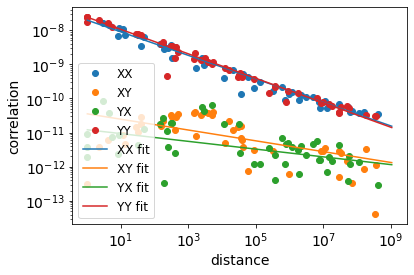

a1= 0.0001224744871391589 a2= 0.0002449489742783178


In [3]:
def combine_data(datas,names):
    all_data=datas[0].copy()
    for name,data in zip(names,datas):
        assert all(data[x].equals(all_data[x]) for x in ['x0','x1','y0','y1'])
        all_data[name]=data['correlation']
    all_data=all_data.drop(columns=[x for x in all_data.columns if x.startswith('op')]+['correlation'])
    return all_data

folder_name='data/akltStrange_X24/a1_0.0001225_a2_0.0002449'
data1=process_data(folder_name+'/correlation_XX.pkl',log2Size=30)
data2=process_data(folder_name+'/correlation_XY.pkl',log2Size=30)
data3=process_data(folder_name+'/correlation_YX.pkl',log2Size=30)
data4=process_data(folder_name+'/correlation_YY.pkl',log2Size=30)

data=combine_data([data1,data2,data3,data4],['XX','XY','YX','YY'])
del data1,data2,data3,data4

row=data.iloc[0];a1,a2=row['a1'],row['a2']
bounds=([0,.01],[3,1])
p0=(a1**2,.015)
p1,cov1,ansatz1=fit_data(data,critical_correlation,name='XX',cutoff=0,bounds=bounds,p0=p0)
p2,cov2,ansatz2=fit_data(data,critical_correlation,name='XY',cutoff=0,bounds=bounds,p0=p0)
p3,cov3,ansatz3=fit_data(data,critical_correlation,name='YX',cutoff=0,bounds=bounds,p0=p0)
p4,cov4,ansatz4=fit_data(data,critical_correlation,name='YY',cutoff=0,bounds=bounds,p0=p0)

ls=np.geomspace(1,2**30)

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
plt.plot(data['dist'],data['XX'],'o',label='XX',c='C0')
plt.plot(data['dist'],data['XY'],'o',label='XY',c='C1')
plt.plot(data['dist'],data['YX'],'o',label='YX',c='C2')
plt.plot(data['dist'],data['YY'],'o',label='YY',c='C3')

plt.plot(ls,critical_correlation(ls,*p1),label='XX fit',c='C0')
plt.plot(ls,critical_correlation(ls,*p2),label='XY fit',c='C1')
plt.plot(ls,critical_correlation(ls,*p3),label='YX fit',c='C2')
plt.plot(ls,critical_correlation(ls,*p4),label='YY fit',c='C3')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance')
plt.ylabel('correlation')
# plt.ylim([1e-6,1])
plt.legend()
plt.show()
print('a1=',a1,'a2=',a2)



In [3]:
from glob import glob

folder_names=sorted(glob('data/akltStrange_X24/*/'))

scdim_data=[]

for folder_name in folder_names:
    dataXX=process_data(folder_name+'/correlation_XX.pkl',log2Size=30)
    dataYY=process_data(folder_name+'/correlation_YY.pkl',log2Size=30)
    row=dataXX.iloc[0];a1,a2=row['a1'],row['a2']
    try:
        bounds=([0,.01],[3,1])
        p0=(a1**2,.015)
        p1,cov1,ansatz1=fit_data(dataXX,critical_correlation,name='correlation',cutoff=0,print_result=False,bounds=bounds,p0=p0)
        p2,cov2,ansatz2=fit_data(dataYY,critical_correlation,name='correlation',cutoff=0,print_result=False,bounds=bounds,p0=p0)
        min_XX,min_YY,max_XX,max_YY=np.min(dataXX['correlation']),np.min(dataYY['correlation']),np.max(dataXX['correlation']),np.max(dataYY['correlation'])
        scdim_data.append({'a1':a1,'a2':a2,'delta_XX':p1[1],'delta_YY':p2[1],'A_XX':p1[0],'A_YY':p2[0],'min_XX':min_XX,'min_YY':min_YY,'max_XX':max_XX,'max_YY':max_YY})
        print('a1:',a1,'a2:',a2,'delta_XX:',p1[1],'delta_YY:',p2[1],'A_XX:',p1[0],'A_YY:',p2[0],'min_XX:',min_XX,'min_YY:',min_YY,'max_XX:',max_XX,'max_YY:',max_YY)
    except ValueError as e:
        print('a1:',a1,'a2:',a2,'error:',e)

scdim_data=pd.DataFrame(scdim_data)

a1: 0.0 a2: 0.0 error: no data above cutoff=0
a1: 0.0001224744871391589 a2: 0.0002449489742783178 delta_XX: 0.17185924383199752 delta_YY: 0.1789030323852159 A_XX: 1.959902765193456e-08 A_YY: 2.3986098700670986e-08 min_XX: -2.4949632850606216e-08 min_YY: -1.6080278830025907e-08 max_XX: 1.608028679423945e-08 max_YY: 2.4949627206304538e-08
a1: 0.00019410898091701923 a2: 0.0003882179618340385 delta_XX: 0.16009294856422818 delta_YY: 0.16704424720357497 A_XX: 4.468031632399441e-08 A_YY: 5.610020085898938e-08 min_XX: -6.267063174517392e-08 min_YY: -4.0392461291252696e-08 max_XX: 4.039245856094542e-08 max_YY: 6.26706337144352e-08
a1: 0.0003076420024509478 a2: 0.0006152840049018956 delta_XX: 1.5062454262197336 delta_YY: 1.6737499394045243 A_XX: 0.004899432220980601 A_YY: 0.5595518466913011 min_XX: -1.5742153079243072e-07 min_YY: -1.0145878386183214e-07 max_XX: 1.0145878386186651e-07 max_YY: 1.5742153079240634e-07
a1: 0.00048757971539961257 a2: 0.0009751594307992253 delta_XX: 0.15234822846749652

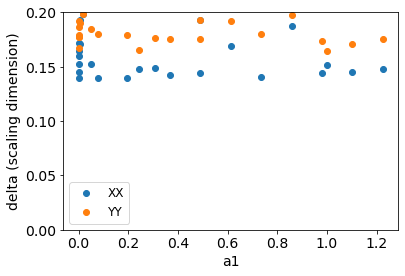

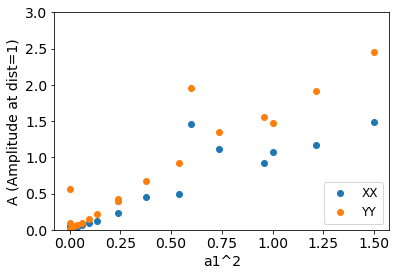

In [4]:
scdim_data

plt.plot(scdim_data['a1'],scdim_data['delta_XX'],'o',label='XX')
plt.plot(scdim_data['a1'],scdim_data['delta_YY'],'o',label='YY')
plt.xlabel('a1')
plt.ylabel('delta (scaling dimension)')
plt.ylim([0,.2])
plt.legend()
plt.show()

plt.plot(scdim_data['a1']**2,scdim_data['A_XX'],'o',label='XX')
plt.plot(scdim_data['a1']**2,scdim_data['A_YY'],'o',label='YY')
plt.xlabel('a1^2')
plt.ylabel('A (Amplitude at dist=1)')
plt.ylim([0,3])
plt.legend()
plt.show()